# 1. Loading the libraries

In [13]:
import cv2
import pandas as pd
from matplotlib.pyplot import imshow 
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
import numpy as np
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout
import matplotlib.pyplot as plt
import datetime, os, time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [2]:
os.chdir("/home/kanaad/Desktop/Strathclyde/Project/IchMLP/HHP/simulation/cropped pas stained images hhp - 2/")

# 2. Construct Images from path

In [3]:
def construct_data(height,width,color):
    df = pd.DataFrame()
    sci = pd.read_csv('areas_.csv')
    sci = sci.rename(columns={'Unnamed: 0':'file_name'})
    df['sci_area'] = sci['area']
    df['sci_count'] = sci['count']
    df['file_name'] = sci['file_name']
    X = []
    y = []
    for i in tqdm(range(len(df))):
        file = df['file_name'].iloc[i] + ".jpg"
        try:
            if color == 'c':
                img_bw = cv2.imread(file,cv2.IMREAD_COLOR)
            elif color == 'b':
                img_bw = cv2.imread(file,cv2.IMREAD_GRAYSCALE)

            img_bw = cv2.resize(img_bw,(height,width))
            img =  np.array(img_bw) 
            X.append(img)
            sc = df['sci_area'].iloc[i]
            y.append(sc)
        except Exception as e:
            pass
    return np.asarray(X) ,np.asarray(y) 
    

# 3. Loading the data

In [4]:
X, y = construct_data(224,224,'c')

100%|██████████| 439/439 [00:22<00:00, 19.69it/s]


In [5]:
X = X / 255.0

# 4. Scaling the data

In [6]:
import seaborn as sns
scaler = preprocessing.MinMaxScaler()
y = np.log(y)
y = y.reshape(-1,1)
y = scaler.fit_transform(y)
y = y.reshape(-1,)

# 5. Splitting the data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [8]:
print(f'Shape of X_train : {X_train.shape} | Shape of X_test : {X_test.shape} | Shape of y_train : {y_train.shape} | Shape of y_test : {y_test.shape}')

Shape of X_train : (368, 224, 224, 3) | Shape of X_test : (66, 224, 224, 3) | Shape of y_train : (368,) | Shape of y_test : (66,)


# 6. Defining the ResNet50 Model

In [48]:
def create_model(input_shape, top='flatten'):
    if top not in ('flatten', 'avg', 'max'):
        raise ValueError('unexpected top layer type: %s' % top)

    # connects base model with new "head"
    BottleneckLayer = {
        'flatten': Flatten(),
        'avg': keras.layers.GlobalAveragePooling2D,
        'max': keras.layers.GlobalAveragePooling2D
    }[top]

    base = ResNet50(input_shape=input_shape,
                             include_top=False, 
                             weights='imagenet',classes=1)

    x = Flatten()(base.output)
    x = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=base.inputs, outputs=x)
    
    return model

# 7. Calling TensorBoard

In [49]:
logs_base_dir = "./ResNetLogs"
os.makedirs(logs_base_dir, exist_ok=True)
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5819), started 0:14:00 ago. (Use '!kill 5819' to kill it.)

In [50]:
model = create_model(X.shape[1:])
model.compile(optimizer = 'adam',loss='mse',metrics=['mse'])
es = EarlyStopping(patience=20,restore_best_weights=True)
logdir = os.path.join(logs_base_dir, "Resnet50")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# 8. Training the model

In [51]:
history = model.fit(X_train, y_train,validation_data=(X_test,y_test),callbacks=[tensorboard_callback,es],verbose=1,epochs=30,batch_size=16)

Train on 368 samples, validate on 66 samples
Epoch 1/30
368/368 [==============================] - 10s 27ms/sample - loss: 0.2235 - mse: 0.2235 - val_loss: 0.2426 - val_mse: 0.2426
Epoch 2/30
368/368 [==============================] - 6s 15ms/sample - loss: 0.0742 - mse: 0.0742 - val_loss: 0.2426 - val_mse: 0.2426
Epoch 3/30
368/368 [==============================] - 6s 16ms/sample - loss: 0.0637 - mse: 0.0637 - val_loss: 0.2426 - val_mse: 0.2426
Epoch 4/30
368/368 [==============================] - 6s 15ms/sample - loss: 0.0576 - mse: 0.0576 - val_loss: 0.0295 - val_mse: 0.0295
Epoch 5/30
368/368 [==============================] - 6s 15ms/sample - loss: 0.0594 - mse: 0.0594 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 6/30
368/368 [==============================] - 6s 15ms/sample - loss: 0.0643 - mse: 0.0643 - val_loss: 0.3167 - val_mse: 0.3167
Epoch 7/30
368/368 [==============================] - 6s 15ms/sample - loss: 0.0569 - mse: 0.0569 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 8/3

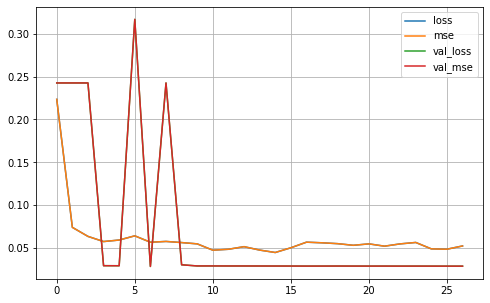

In [52]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim()
plt.show()

# 9. Visualising the predictions

In [53]:
def pred_img(inst,vis):
    predicted = X_train[inst].reshape(1,X.shape[1],X.shape[1],3)
    predicted = tf.convert_to_tensor(predicted)
    predicted = tf.cast(predicted,dtype=tf.float16)
    predicted_result = model.predict(predicted)
    predicted_result = np.array(predicted_result)
    scaled_result = scaler.inverse_transform(predicted_result)[0][0]
    scaled_result = np.exp(scaled_result)
    actual = y_train[inst]
    actual = np.reshape(actual,(-1,1))
    actual = scaler.inverse_transform(actual)[0][0]
    actual = np.exp(actual)
    error  = (abs(scaled_result - actual) / actual) * 100

    if vis:
        print(f'Prediction  = {scaled_result}')
        print(f'Actual = {actual}')
        print(f'Difference in predictions {abs(actual-scaled_result ) : .2f}')
        print(f'Error : {error : .2f} %')
        img = tf.cast(X_train[inst],dtype=tf.float32)
        plt.imshow(img)
        
    
    return error,actual,scaled_result

Prediction  = 9674.251953125
Actual = 2786.0000000000005
Difference in predictions  6888.25
Error :  247.25 %


(247.24522444813348, 2786.0000000000005, 9674.252)

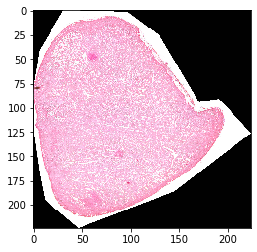

In [54]:
pred_img(6,vis=True)

# 10. Testing the model

In [55]:
def test_model(data):
    errs = []
    actuals = []
    predicted_ = []
    if data == 'test':
        ds = X_test
    else:
        ds = X_train
        
    for i in tqdm(range(len(ds))):
        error,actual,predicted = pred_img(i,vis=False)
        errs.append(error)
        actuals.append(actual)
        predicted_.append(predicted)
    print(f'Mean Error : {np.mean(errs)}')
    
    return errs,actuals,predicted_

In [56]:
errors,actuals,predicted = test_model('test')

100%|██████████| 66/66 [00:02<00:00, 32.39it/s]

Mean Error : 474.5811545774624


In [ ]:
errors